# Notebook III - Climatic Constraints

<hr>
This module uses various yield reduction factors to apply the obtained maximum attainable yield from Module 2 to consider the constraint effects separately from Module II. This modules works with two separate python look-up scripts ALL_REDUCTION_FACTORS_IRR and ALL_REDUCTION_FACTORS_RAIN which must be manually edited for crop/LUT specific reduction factors.

Prepared by Geoinformatics Center, AIT
<hr>

### Google drive connection
In this step, we will connect to Google Drive service and mount the drive where we will start our PyAEZ project

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Then, installing any additional python packages that required to run PyAEZ.
If working on your own PC/machine, these additional installation will vary depending on what is already installed in your Python library. 

In [ ]:
# 'Installing neccessary packages'
# !pip install gdal

## Importing Libraries

In [2]:
'''import supporting libraries'''
# import pyaez
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
try:
    from osgeo import gdal
except:
    import gdal
import sys

Setting the working directory -- where our PyAEZ project is located.

In [3]:
'Set the working directory'
work_dir = r'D:\test_working_folder'  # Please change this to your working directory
os.chdir(work_dir)
sys.path.append(r'D:\PyAEZ_iiasa')
os.getcwd()


'D:\\test_working_folder'

Check and create data output folder

In [4]:
import os
folder_path = './data_output/NB3/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Folder created successfully.")
else:
    print("Folder already exists.")


Folder already exists.


Preparing required inputs for object class

In [5]:
lat_min = 13.87
lat_max = 22.59
mask_value = 0  # pixel value in admin_mask to exclude from the analysis
elevation = gdal.Open(r'D:\PyAEZ_iiasa\data_input/LAO_Elevation.tif').ReadAsArray()

mask_path = r'D:\PyAEZ_iiasa\data_input/LAO_Admin.tif'
mask = gdal.Open(mask_path).ReadAsArray()

Importing all necessary yield, agro-climatic indicators and climate data

In [6]:
# Climate data
max_temp = np.load(r'D:\PyAEZ_iiasa\data_input\climate/max_temp.npy')  # maximum temperature
min_temp = np.load(r'D:\PyAEZ_iiasa\data_input\climate/min_temp.npy')  # minimum temperature
precipitation = np.load(r'D:\PyAEZ_iiasa\data_input\climate/precipitation.npy')  # precipitation
rel_humidity = np.load(r'D:\PyAEZ_iiasa\data_input\climate/relative_humidity.npy')  # relative humidity
wind_speed = np.load(r'D:\PyAEZ_iiasa\data_input\climate/wind_speed.npy') # wind speed measured at two meters
short_rad = np.load(r'D:\PyAEZ_iiasa\data_input\climate/short_rad.npy')  # shortwave radiation

# Agro-climatic Indicators
lgp = gdal.Open(r'./data_output/NB1/LAO_LGP.tif').ReadAsArray()
lgp_equv = gdal.Open(r'./data_output/NB1/LAO_LGPEquivalent.tif').ReadAsArray()
lgp10 = gdal.Open(r'./data_output/NB1/LAO_LGPt10.tif').ReadAsArray()

# Yield Map
yield_map_rain = gdal.Open(r'./data_output/NB2/maiz_yld_rain.tif').ReadAsArray()
yield_map_irr = gdal.Open(r'./data_output/NB2/maiz_yld_irr.tif').ReadAsArray()

## Applying Climate Constraints

In [7]:
'''importing library'''

from pyaez import ClimaticConstraints
clim_con = ClimaticConstraints.ClimaticConstraints(lat_min = lat_min, lat_max =lat_max, 
                                                   elevation=elevation, mask = mask , 
                                                   no_mask_value=0)

from pyaez import UtilitiesCalc
obj_utilities = UtilitiesCalc.UtilitiesCalc()

Importing climate data into the object class

In [8]:
clim_con.setClimateData(min_temp= min_temp, max_temp= max_temp, wind_speed= wind_speed,
                        short_rad= short_rad, rel_humidity= rel_humidity, precip= precipitation)

Agro-climatic Reduction Factors are now set up for a single water supply condition with
the excel sheet

In [9]:
# In this notebook, we will explore for rainfed conditons' agro-climatic constraints
clim_con.setReductionFactors(file_path= r'D:\PyAEZ_iiasa\data_input\maiz_fc3_rain_lst.xlsx')

In [10]:
'''Applying climatic constraints. Note that constraints for rainfed and irrigated conditions are run separately'''
# Yield Reduction for Rainfed Conditions
clim_con.applyClimaticConstraints(yield_input=yield_map_rain, lgp=lgp, lgp_equv=lgp_equv, 
                                  lgpt10=lgp10, omit_yld_0 = True)


# Getting the climate adjusted yield (rainfed)
clim_yield_rain_maiz = clim_con.getClimateAdjustedYield()

# Getting agro-climatic constraint factor (fc3) (rainfed)
fc3_maiz_rain = clim_con.getClimateReductionFactor()

Text(0.5, 1.0, 'Fc3 Maize Rainfed')

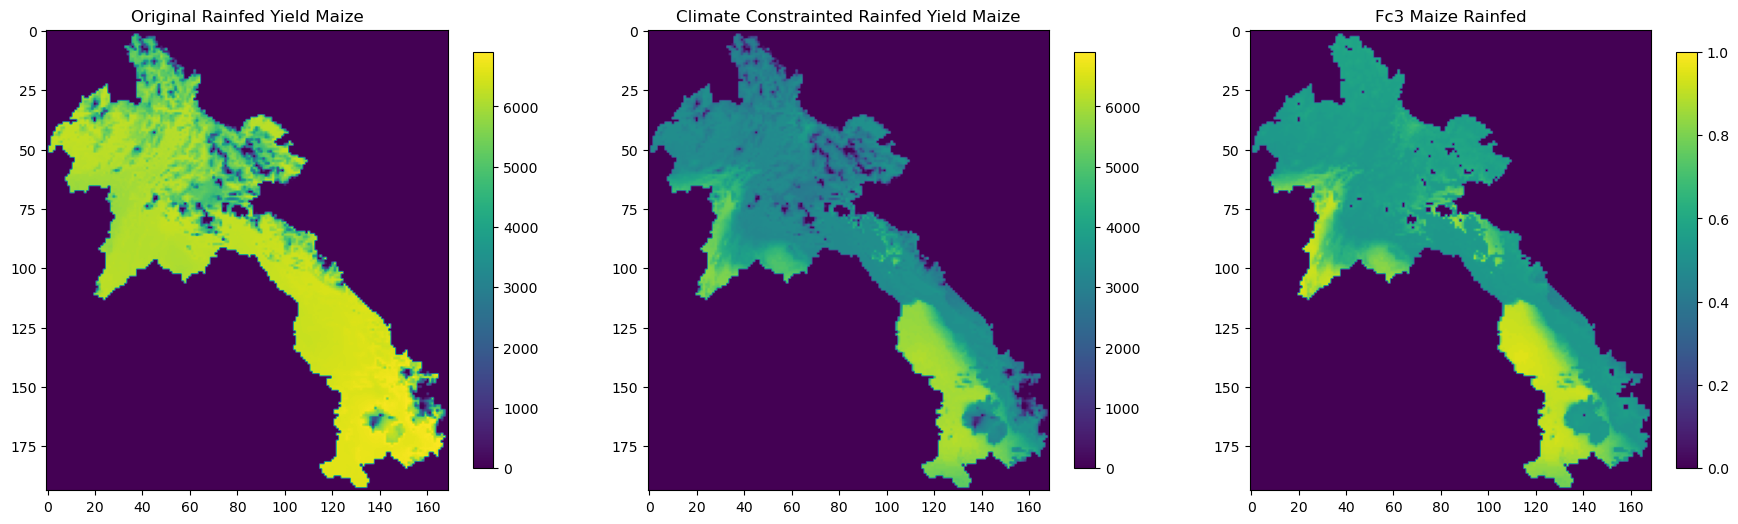

In [11]:
'''visualize results'''
plt.figure(1, figsize=(22,9))
plt.subplot(1,3,1)
plt.imshow(yield_map_rain, vmax = np.max([clim_yield_rain_maiz, yield_map_rain]))
plt.colorbar(shrink=0.6)
plt.title('Original Rainfed Yield Maize')

plt.subplot(1,3,2)
plt.imshow(clim_yield_rain_maiz, vmax = np.max([clim_yield_rain_maiz, yield_map_rain]))
plt.colorbar(shrink=0.6)
plt.title('Climate Constrainted Rainfed Yield Maize')

plt.subplot(1,3,3)
plt.imshow(fc3_maiz_rain, vmax = 1)
plt.colorbar(shrink=0.6)
plt.title('Fc3 Maize Rainfed')


In [12]:
'''save result (Rainfed Condition)'''
obj_utilities.saveRaster(mask_path, r'./data_output/NB3/clim_maiz_yld_rain.tif', clim_yield_rain_maiz)
obj_utilities.saveRaster(mask_path, r'./data_output/NB3/fc3_maiz_rain.tif', fc3_maiz_rain)

Let's run same this for irrigated condition

In [13]:
# In this notebook, we will explore for rainfed conditons' agro-climatic constraints
clim_con.setReductionFactors(file_path= r'D:\PyAEZ_iiasa\data_input\maiz_fc3_irr_lst.xlsx')

In [14]:
'''Applying climatic constraints. Note that constraints for rainfed and irrigated conditions are run separately'''
# Yield Reduction for Rainfed Conditions
clim_con.applyClimaticConstraints(yield_input=yield_map_irr, lgp=lgp, lgp_equv=lgp_equv, 
                                  lgpt10=lgp10, omit_yld_0 = True)


# Getting the climate adjusted yield (rainfed)
clim_yield_irr_maiz = clim_con.getClimateAdjustedYield()

# Getting agro-climatic constraint factor (fc3) (rainfed)
fc3_maiz_irr = clim_con.getClimateReductionFactor()

Text(0.5, 1.0, 'Fc3 Maize Irrigated')

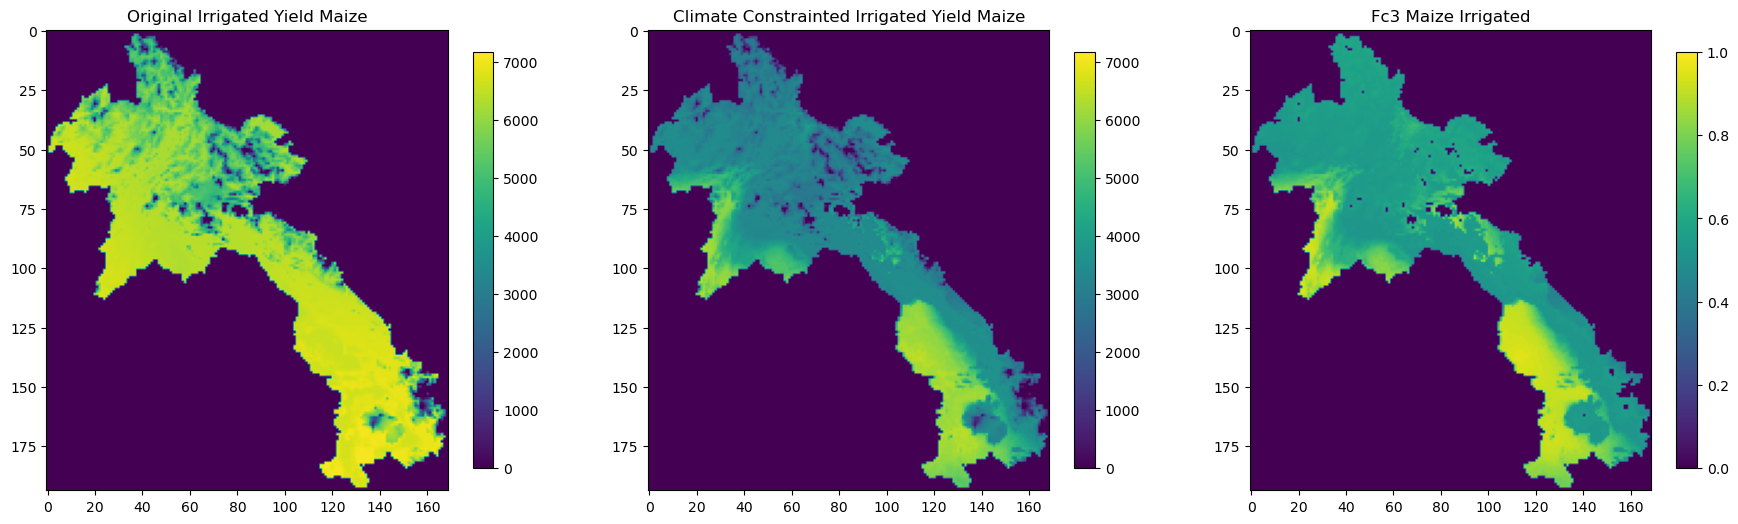

In [15]:
'''visualize results'''
plt.figure(1, figsize=(22,9))
plt.subplot(1,3,1)
plt.imshow(yield_map_irr, vmax = np.max([clim_yield_irr_maiz, yield_map_irr]))
plt.colorbar(shrink=0.6)
plt.title('Original Irrigated Yield Maize')

plt.subplot(1,3,2)
plt.imshow(clim_yield_irr_maiz, vmax = np.max([clim_yield_irr_maiz, yield_map_irr]))
plt.colorbar(shrink=0.6)
plt.title('Climate Constrainted Irrigated Yield Maize')

plt.subplot(1,3,3)
plt.imshow(fc3_maiz_rain, vmax = 1)
plt.colorbar(shrink=0.6)
plt.title('Fc3 Maize Irrigated')


In [16]:
'''save result (Irrigated Condition)'''
obj_utilities.saveRaster(mask_path, r'./data_output/NB3/clim_maiz_yld_irr.tif', clim_yield_irr_maiz)
obj_utilities.saveRaster(mask_path, r'./data_output/NB3/fc3_maiz_irr.tif', fc3_maiz_irr)

<hr>

### END OF MODULE 3: CLIMATIC CONSTRAINTS

<hr>